In [539]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import yfinance as yf
import hvplot.pandas
from pathlib import Path
from finta import TA
import matplotlib.pyplot as plt
import quantstats as qs
import itertools
from IPython.display import clear_output
from collections import Counter as CounterClass

In [154]:
pd.set_option('display.max_colwidth', None)

In [155]:
### Quant framework 3 x 3 x 3

#     Intraday   >>Swing<<    >>Position<<

#     Earnings     Event      >>TA<<

#   >>Delta<<      Theta        Vega

# Project 2 scope is focused on Swing and Position timeframe, while relying on TA
# to determine signals. Option strategies are not used.

### Technical goal:

# Automate creation and testing of new trading algorithms based on our framework

### Plan:

# 1. Pull the data: ohlc + volume ✓
# 2. Integrate Finta with our data ✓
# 3. Determine trading signals for testable indicators (crossovers, etc.)✓
# 4. Test the strategy on data of 2017 - 2019 
# 5. Automate testing of different combinations of strategies
# 6. Train ML algorithms on best performing strategies
# 7. Deploy trained ML algorithms and test performance on 2020-2023 data

In [156]:
sqrt = np.sqrt(252)
trading_days_year = 252
total_days_year = 365
thirty_years_ago = (pd.Timestamp.today() - pd.Timedelta(days = total_days_year * 30)).date()
ten_years_ago = (pd.Timestamp.today() - pd.Timedelta(days = total_days_year * 10)).date()
five_years_ago = (pd.Timestamp.today() - pd.Timedelta(days = total_days_year * 5)).date()
three_years_ago = (pd.Timestamp.today() - pd.Timedelta(days = total_days_year * 3)).date()
one_year = (pd.Timestamp.today() - pd.Timedelta(days = total_days_year * 1)).date()
six_months = (pd.Timestamp.today() - pd.Timedelta(days = total_days_year / 2)).date()
yesterday = (pd.Timestamp.today() - pd.Timedelta(days = 1)).date()
sixty_days = (pd.Timestamp.today() - pd.Timedelta(days = 59)).date()
# Portfolio vars

share_size = 100
initial_capital = 100000

# Optionable stocks 
optionable_stocks_path = Path('./Resources/optionable_stocks.csv')
with open(optionable_stocks_path, 'r') as file:
    optionable_stocks = file.read()
optionable_stocks = optionable_stocks.replace('\n', ' ')

# 1. Pull the data: ohlc + volume

In [157]:
def get_data(interval, start, end, seg_window = 21):
    yf_df = yf.Tickers(optionable_stocks)
    df_full =yf_df.history(start = start, end = end, interval= interval)
    stocks = df_full[['Open', 'Close', 'High', 'Low', 'Volume']]
    
    if interval == '5m':
        sqrt_val = 252 * 78 
    elif interval == '15m':
        sqrt_val = 252 * 26  
    elif interval == '30m':
        sqrt_val = 252 * 13 
    elif interval == '1h':
        sqrt_val = 252 * 6.5
    elif interval == '1d':
        sqrt_val = 252
    elif interval == '1wk':
        sqrt_val = 52
        
    stock_names = stocks.columns.get_level_values(1).unique().tolist()

    cumulative_return_column = pd.MultiIndex.from_product([['Rolling_Cumulative_Return'], stock_names])
    volatility_column = pd.MultiIndex.from_product([['Rolling_Volatility'], stock_names])
    sharpe_column = pd.MultiIndex.from_product([['Rolling_Sharpe'], stock_names])
    rank_column = pd.MultiIndex.from_product([['Rank_Sharpe'], stock_names])
    
    df_cumulative_return = pd.DataFrame(0.0, index = stocks.index , columns = cumulative_return_column)
    df_volatility = pd.DataFrame(0.0, index = stocks.index , columns = volatility_column )
    df_sharpe = pd.DataFrame(0.0, index = stocks.index , columns = sharpe_column)
    df_rank = pd.DataFrame(0.0, index = stocks.index , columns = sharpe_column)
    
    for stock in stock_names:
        mask = stocks.columns.get_level_values(1) == stock
        data = stocks.loc[:, mask]
        data.columns = data.columns.droplevel(1)
        close = data['Close']
        returns = data['Close'].pct_change()
        df_cumulative_return[('Rolling_Cumulative_Return', stock)] = (1 + returns).rolling(window=seg_window).apply(lambda x: x.prod())
        df_volatility[('Rolling_Volatility', stock)] = returns.rolling(window=seg_window).std() * np.sqrt(sqrt_val)
        df_sharpe[('Rolling_Sharpe', stock)] = (returns.rolling(window=seg_window).mean() * sqrt_val) / df_volatility[('Rolling_Volatility', stock)]
        
    def rank_row(row):
        return row.rank(ascending=False)

    df_rank = df_sharpe.apply(rank_row, axis=1)
    df_rank.columns = rank_column
    
    final_df = pd.concat([stocks, df_rank], axis = 1)
    
    return final_df


In [158]:
def get_individual_stock(stock, stocks):
    mask = stocks.columns.get_level_values(1) == stock
    data = stocks.loc[:, mask]
    data.columns = data.columns.droplevel(1)
    data.dropna(inplace = True)
    return data

In [159]:
# Pulls data for different time intervals. YF only provides last 60 days worth of intraday data

stocks_1wk = get_data('1wk', '2017-01-01', yesterday)
stocks_1d = get_data('1d', '2017-01-01', yesterday)
stocks_1h = get_data('1h', sixty_days, yesterday)
stocks_30m = get_data('30m', sixty_days, yesterday)
stocks_15m = get_data('15m', sixty_days, yesterday)
stocks_5m = get_data('5m', sixty_days, yesterday)

# gets valid stock names that we can iterate over in Tester()
stock_names = stocks_1d.columns.get_level_values(1).unique().tolist()

[*********************100%***********************]  95 of 95 completed
[*********************100%***********************]  95 of 95 completed
[*********************100%***********************]  95 of 95 completed
[*********************100%***********************]  95 of 95 completed
[*********************100%***********************]  95 of 95 completed
[*********************100%***********************]  95 of 95 completed


# 2. Integrate Finta with our data 

## Getting indicators demo
### Once we have the finalized list of indicators, I will combine them into one function

<Axes: xlabel='Date'>

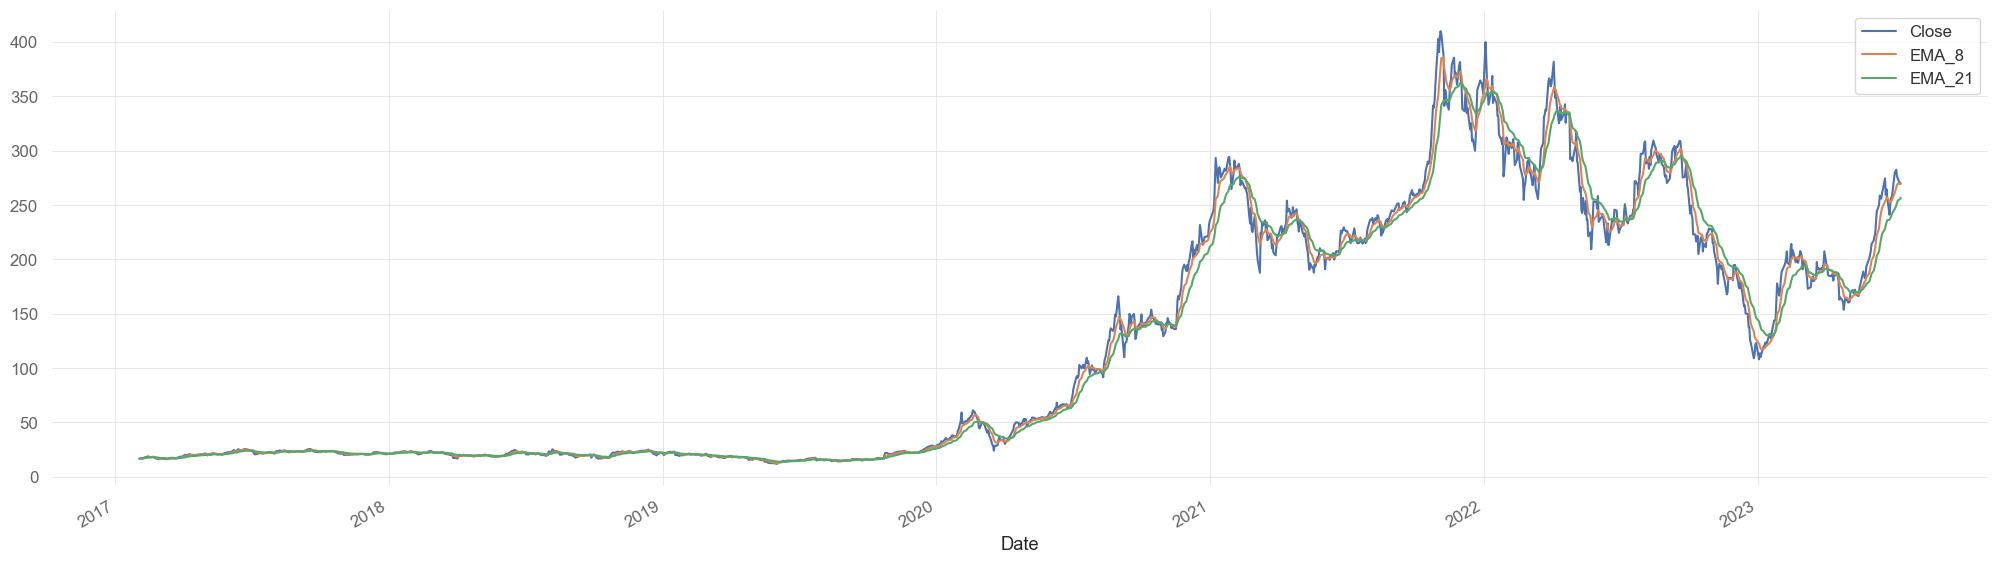

In [160]:
# EMA
short_window = 8
long_window = 21
df = get_individual_stock('TSLA', stocks_1d)
df[f'EMA_{short_window}'] = TA.EMA(df, short_window)
df[f'EMA_{long_window}'] = TA.EMA(df, long_window)
df[['Close', 'EMA_8', 'EMA_21']].plot(figsize = (25,7))

<Axes: xlabel='Date'>

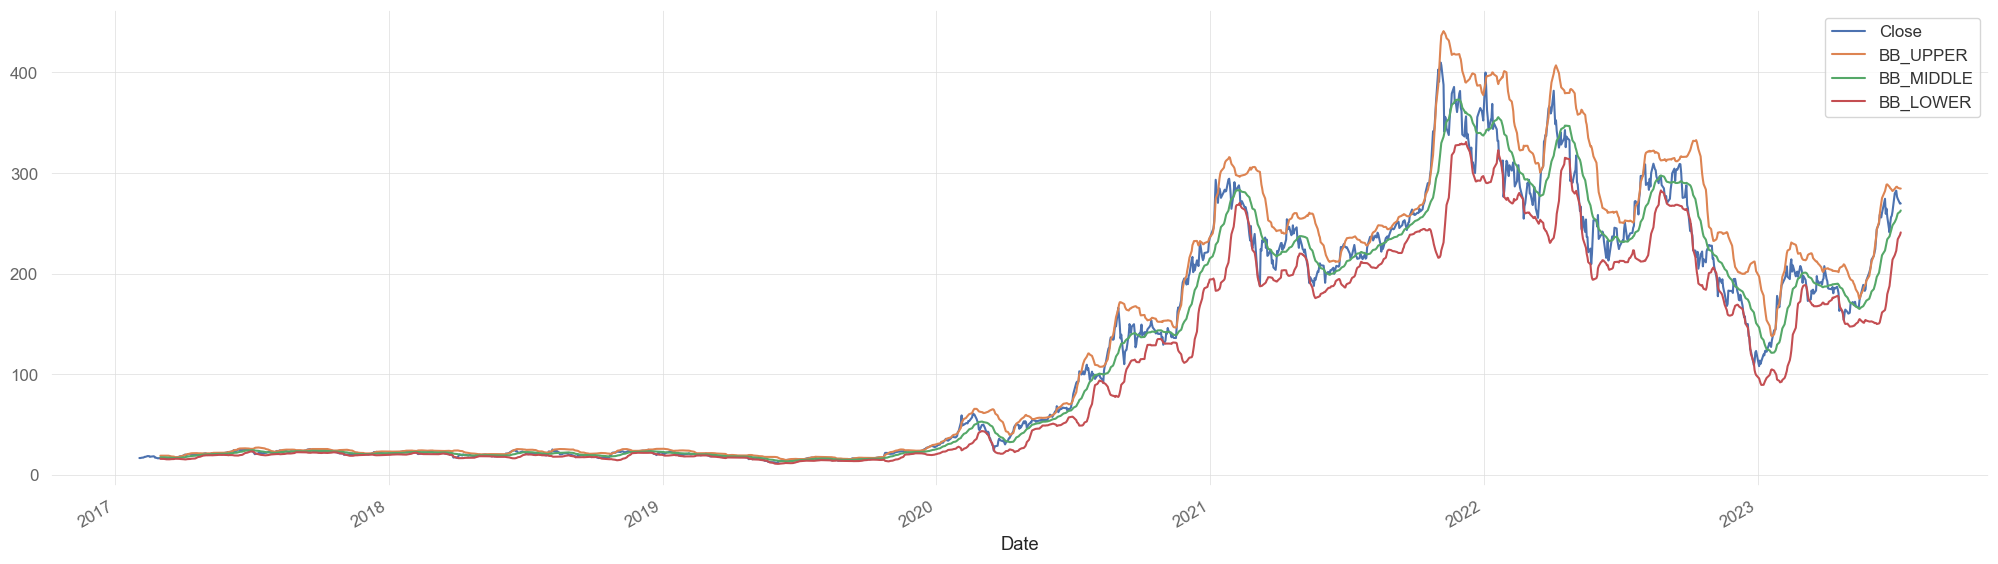

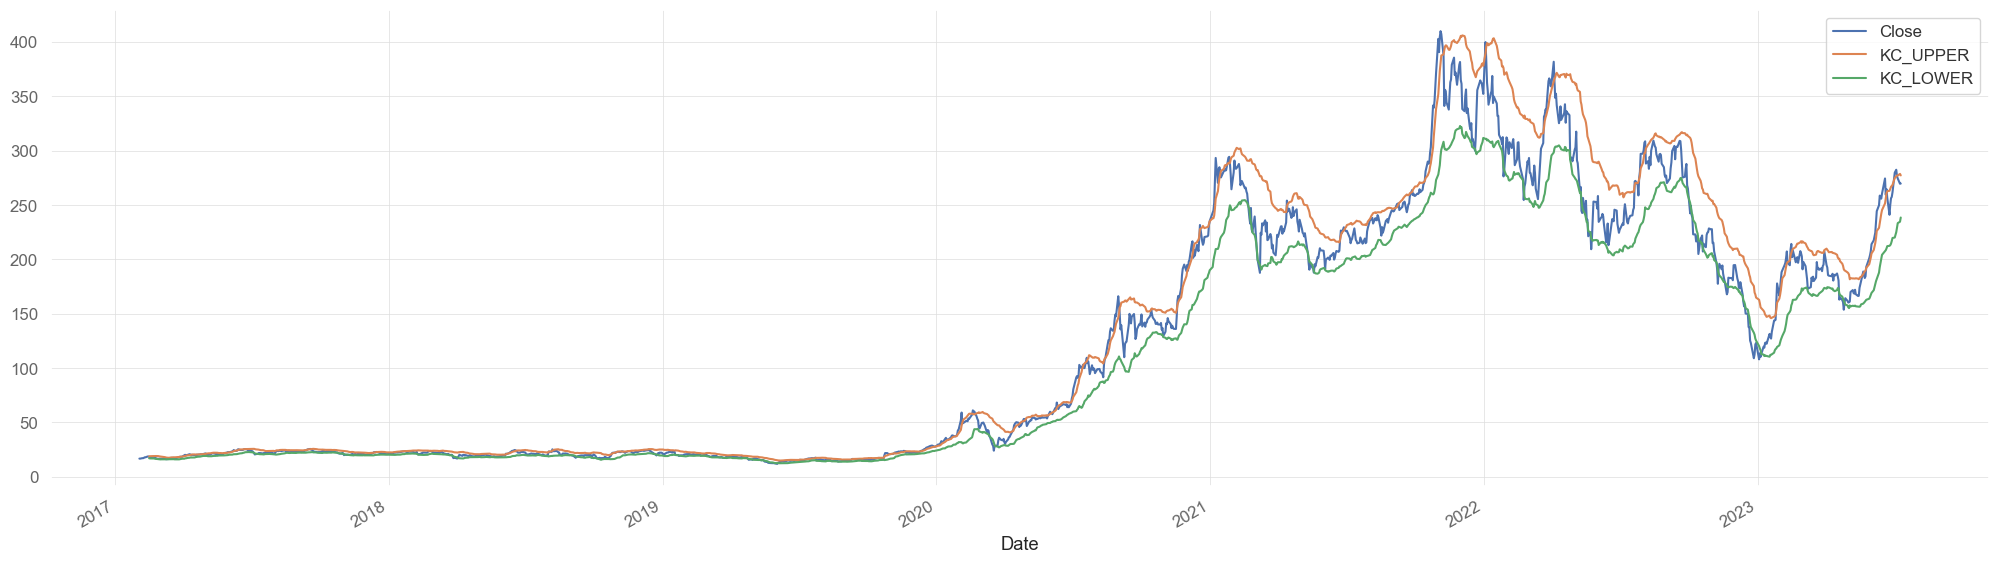

In [161]:
# BBANDS
df[['BB_UPPER','BB_MIDDLE','BB_LOWER']] = TA.BBANDS(df)
df[['Close', 'BB_UPPER','BB_MIDDLE','BB_LOWER']].plot(figsize = (25,7))

# Keltner Channels
df[['KC_UPPER', 'KC_LOWER']] = TA.KC(df)
df[['Close', 'KC_UPPER', 'KC_LOWER']].plot(figsize = (25,7))

<Axes: xlabel='Date'>

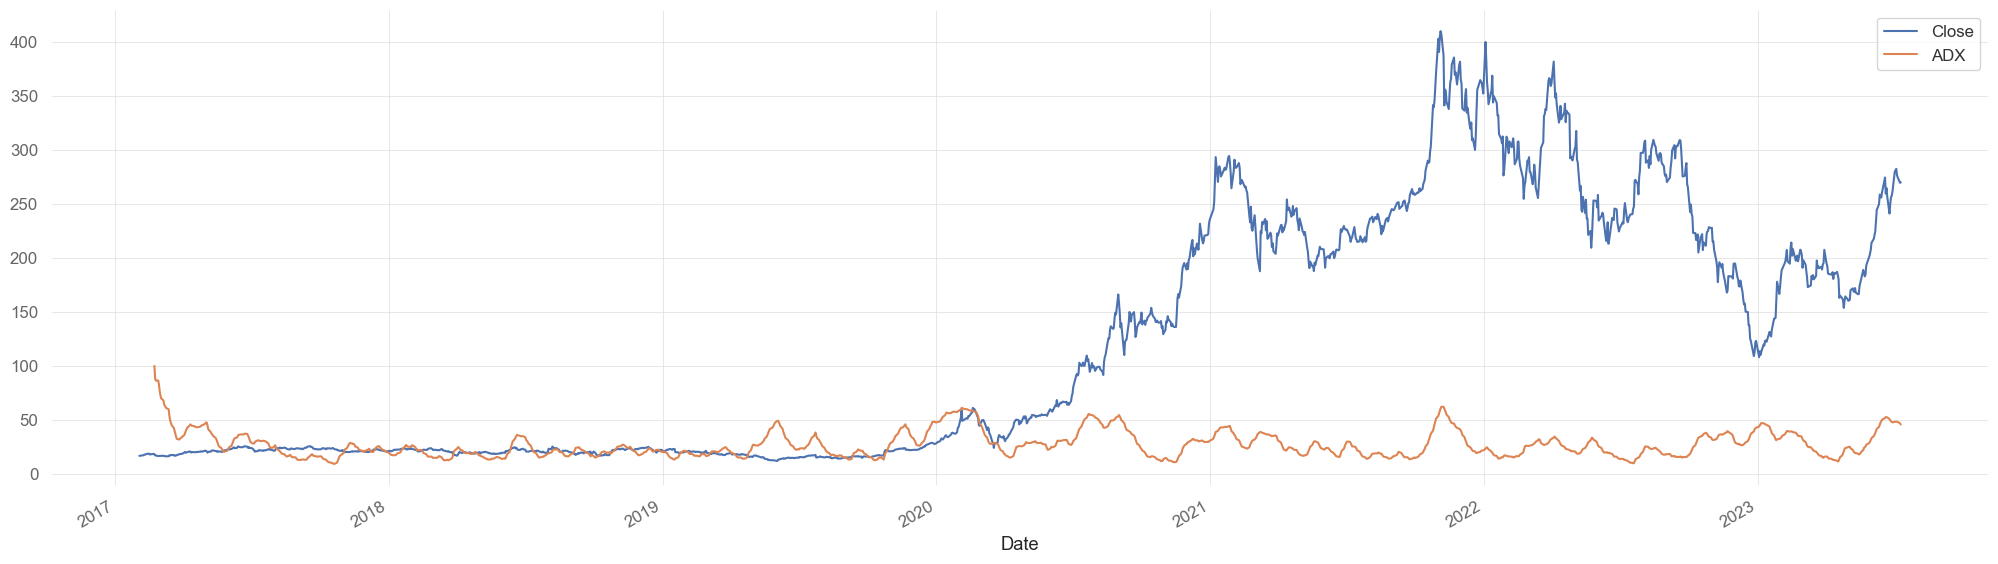

In [162]:
# ADX
df['ADX'] = TA.ADX(df)
df[['Close','ADX']].plot(figsize = (25,7))

<Axes: xlabel='Date'>

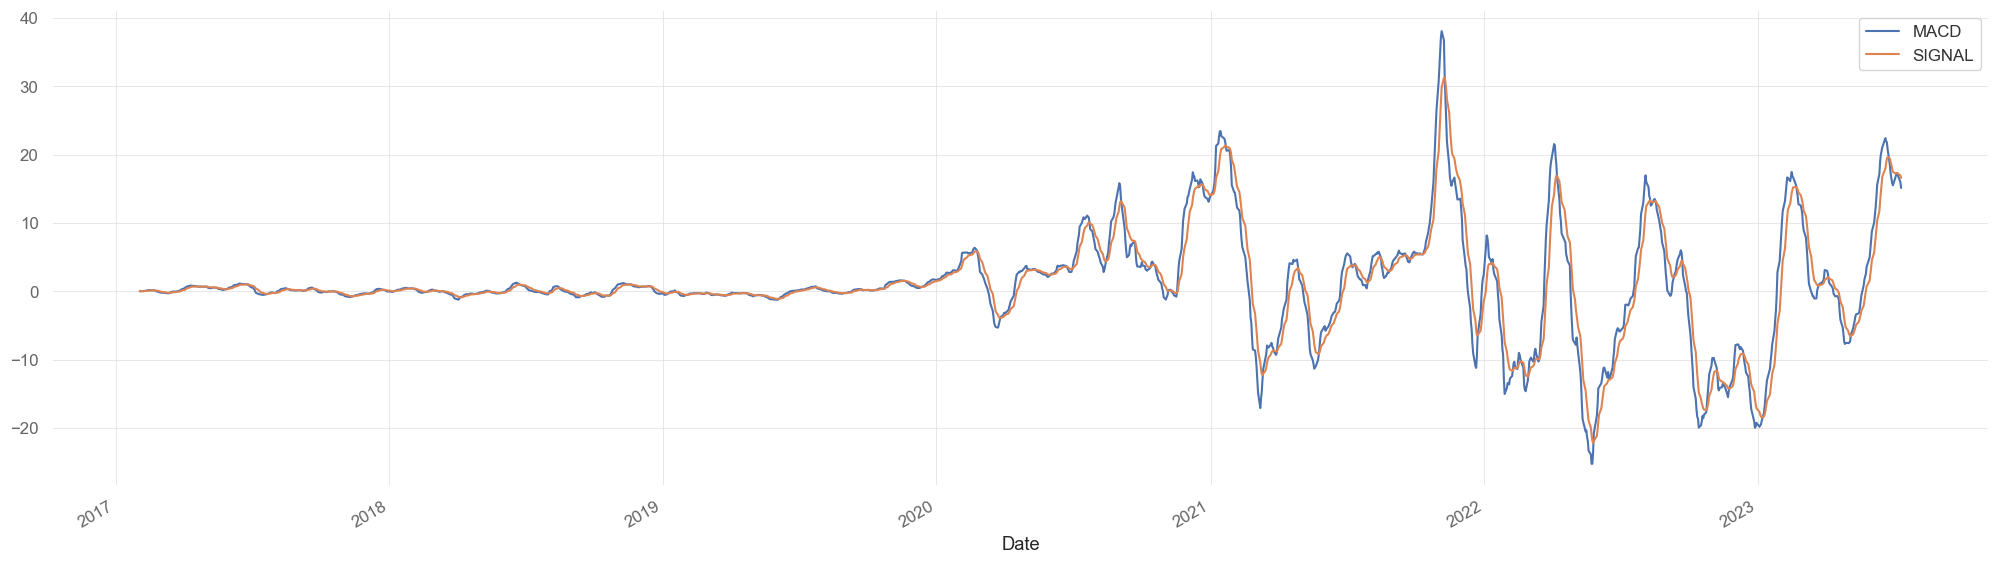

In [163]:
# MACD
df[['MACD', 'SIGNAL']] = TA.MACD(df)

df[['MACD', 'SIGNAL']].plot(figsize = (25,7))


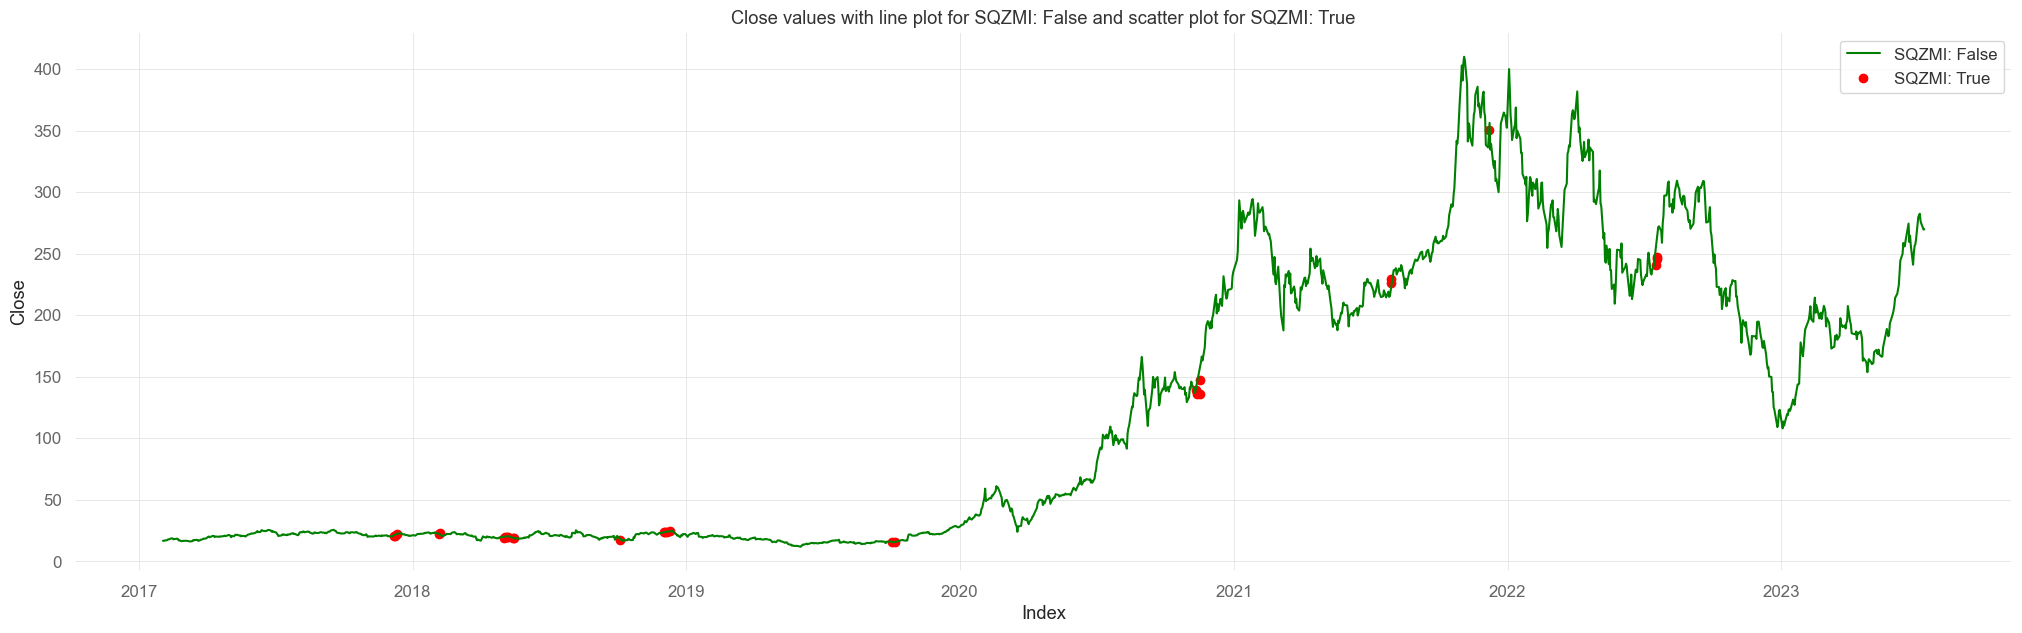

In [164]:
df['SQZMI'] = TA.SQZMI(df)
# Filter the DataFrame based on SQZMI values
false_df = df[df['SQZMI'] == False]
true_df = df[df['SQZMI'] == True]

# Extract the Close values
false_close_values = false_df['Close']
true_close_values = true_df['Close']

# Set the figure size
plt.figure(figsize=(25, 7))  # Adjust the width and height as desired

# Plot the values
plt.plot(false_close_values, color='green', label='SQZMI: False')
plt.scatter(true_df.index, true_close_values, color='red', label='SQZMI: True')
plt.xlabel('Index')
plt.ylabel('Close')
plt.title("Close values with line plot for SQZMI: False and scatter plot for SQZMI: True")
plt.legend()
plt.show()

# 3. Determine trading signals for testable indicators (crossovers, etc.)

# Get data for different intervals

# Iterator Class

In [533]:
# Define a class
class SignalIterator:
    
    # lower bound = has to be lower than this number, upper bound = has to be higher than this number
    def __init__(self, ticker, interval, stocks_df, lower_segment_boundary = 31, upper_segment_boundary = 0):
        
        if interval == '5m':
            self.sqrt_val = 252 * 78 
        elif interval == '15m':
            self.sqrt_val = 252 * 26  
        elif interval == '30m':
            self.sqrt_val = 252 * 13 
        elif interval == '1h':
            self.sqrt_val = 252 * 6.5
        elif interval == '1d':
            self.sqrt_val = 252
        elif interval == '1wk':
            self.sqrt_val = 52
            
        print(self.sqrt_val)
        
        self.lower_bound = lower_segment_boundary
        self.upper_bound = upper_segment_boundary
        self.stocks_df = stocks_df
        self.interval = interval
        self.ticker = ticker
        
        # Call the basic methods in the __init__ constructor to be immediately executed
        
        self.get_individual_stock()
        self.indicators()
        self.signals()

    def get_individual_stock(self):
        mask = self.stocks_df.columns.get_level_values(1) == self.ticker
        self.df = self.stocks_df.loc[:, mask]
        self.df.columns = self.df.columns.droplevel(1)
        self.df.dropna(inplace = True, axis = 0)
        
    def indicators(self):
        
        # EMA
        self.df['EMA_10'] = TA.EMA(self.df, 10)
        
        # EMA
        self.df['EMA_20'] = TA.EMA(self.df, 20)
        
         # EMA
        self.df['EMA_50'] = TA.EMA(self.df, 50)
        
        # BBANDS
        self.df[['BB_UPPER','BB_MIDDLE','BB_LOWER']] = TA.BBANDS(self.df, std_multiplier= 3)
        
        # SQZ setup
        self.df['SQZ'] = TA.SQZMI(self.df)
        
        # ADX
        self.df['ADX'] = TA.ADX(self.df)
        self.df['ADX_MEAN'] = self.df['ADX'].rolling(window = 90).mean()
        
        # MACD
        self.df[['MACD', 'SIGNAL']] = TA.MACD(self.df)
        
        # CHAIKIN
        self.df['CHAIKIN'] = TA.CHAIKIN(self.df)
        
        # MFI
        self.df['MFI'] = TA.MFI(self.df)
   
    def signals(self):
        
        ### SEGMENTATION ###
        
        self.df['Segmentation_Signal'] = 0.0
        self.df['Segmentation_Signal'] = np.where(
        (self.df['Rank_Sharpe'] <= self.lower_bound) & (self.df['Rank_Sharpe'] >= self.upper_bound), 1.0, 0.0)
        
        ### BUY SIGNALS ###
        
        # EMA Signal logic
        self.df['EMA20_Signal'] = 0.0
        self.df['EMA20_Signal'] = np.where((self.df['Close'] > self.df['EMA_20']), 1.0, 0.0)
        
        # EMA Signal logic
        self.df['EMA50_Signal'] = 0.0
        self.df['EMA50_Signal'] = np.where((self.df['Close'] > self.df['EMA_50']), 1.0, 0.0)
        
        # SQZ Signal logic
        self.df['SQZ_Signal'] = 0.0
        self.df['SQZ_Signal'] = np.where(self.df['SQZ'] == False, 1.0, 0.0)
        
        # ADX Signal logic
        self.df['ADX_Signal'] = 0.0
        self.df['ADX_Signal'] = np.where(self.df['ADX'] > self.df['ADX_MEAN'], 1.0, 0.0)
        
        # MACD Signal logic
        self.df['MACD_Signal'] = 0.0
        self.df['MACD_Signal'] = np.where(self.df['MACD'] > self.df['SIGNAL'], 1.0, 0.0)        
        
        # CHAIKIN Signal logic
        self.df['CHAIKIN_Signal'] = 0.0
        self.df['CHAIKIN_Signal'] = np.where(self.df['CHAIKIN'] > 0, 1.0, 0.0)        
        
        # MFI Signal logic
        self.df['MFI_Signal'] = 0.0
        self.df['MFI_Signal'] = np.where(self.df['MFI'] < 20, 1.0, 0.0)    
        
        ### SELL SIGNALS ###
        
        # BBANDS Sell Signal Logic
        self.df['BB_Sell_Signal'] = 0.0
        self.df['BB_Sell_Signal'] = np.where((self.df['Close'] > self.df['BB_UPPER']), 0.0, 1.0)        
        
    def result(self):
        
        eval_df = pd.DataFrame()
        
        # Define the signal column names
        buy_signal_columns = ['EMA50_Signal','EMA20_Signal','MACD_Signal','SQZ_Signal','CHAIKIN_Signal','MFI_Signal']
        sell_signal_columns = ['BB_Sell_Signal','EMA20_Signal', 'MACD_Signal','ADX_Signal']
        
        # Generate all combinations of signal columns
        for r_buy in range(1, len(buy_signal_columns) + 1):
            combinations_buy = list(itertools.combinations(buy_signal_columns, r_buy))

            # Generate all combinations of sell signal columns
            for r_sell in range(1, len(sell_signal_columns) + 1):
                combinations_sell = list(itertools.combinations(sell_signal_columns, r_sell))

                # Iterate over each combination of buy and sell signals
                for combo_buy in combinations_buy:
                    selected_buy_columns = list(combo_buy)
                    selected_buy_columns.append('Segmentation_Signal')
                    
                    for combo_sell in combinations_sell:
                        selected_sell_columns = list(combo_sell)

                        # Initialize the first row of Main_Signal as 0
                        self.df['Main_Signal'] = 0.0
                        self.df['Portfolio Daily Returns'] = 0.0

                        main_signal = self.df['Main_Signal'].values
                        buy_signal_arr = self.df[selected_buy_columns].values
                        sell_signal_arr = self.df[selected_sell_columns].values
                        close = self.df['Close'].values
                        daily_ret = self.df['Portfolio Daily Returns'].values

                        # Iterate over the remaining rows
                        for i in range(1, self.df.shape[0]):
                            previous_signal = main_signal[i - 1]

                            if previous_signal == 0:
                                # Use Buy Signals to determine current signal
                                buy_signal_conditions = np.all(buy_signal_arr[i] == 1)
                                sell_signal_conditions = np.all(sell_signal_arr[i] == 1)
                                main_signal[i] = int(buy_signal_conditions & sell_signal_conditions)

                                # returns logic
                                daily_ret[i] = 0.0

                            else:
                                # Use Sell Signals to determine current signal
                                sell_signal_conditions = np.all(sell_signal_arr[i] == 1)
                                main_signal[i] = int(sell_signal_conditions)

                                # returns logic
                                previous_price = close[i - 1]
                                current_price = close[i]
                                daily_ret[i] = (current_price - previous_price) / previous_price

                        # Entry/Exit logic
                        self.df['Main_Signal'] = main_signal

                        # Performance Metrics
                        self.df['Entry/Exit'] = self.df['Main_Signal'].diff()
                        self.df['Portfolio Daily Returns'] = daily_ret
                        self.df['Portfolio Cumulative Returns'] = (1 + self.df["Portfolio Daily Returns"]).cumprod()
                        self.df['Buy And Hold Return'] = (1 + self.df['Close'].pct_change()).cumprod()

                        # Create a df with performance summary for each combination

                        # append evaluation metrics to a df as a new row
                        ann_ret =  self.df['Portfolio Daily Returns'].mean() * self.sqrt_val
                        cum_ret = self.df['Portfolio Cumulative Returns'].iloc[-1]
                        ann_volat = self.df['Portfolio Daily Returns'].std() * np.sqrt(self.sqrt_val)
                        sharpe = ann_ret / ann_volat
                        buy_and_hold = self.df['Buy And Hold Return'].iloc[-1]
                        bnh_volatility = self.df['Close'].pct_change().std() * np.sqrt(self.sqrt_val)
                        bnh_sharpe = (self.df['Close'].pct_change().mean()* self.sqrt_val) / bnh_volatility
                        
                        new_row = {'Buy Signals' : f'{selected_buy_columns}',
                                   'Sell Signals' : f'{selected_sell_columns}',
                                   'Algo Annualized Return' : ann_ret,
                                   'Algo Cumulative Return' : cum_ret,
                                   'Algo Annual Volatility' : ann_volat,
                                   'Algo Sharpe Ratio' : sharpe,
                                   'BNH Cumulative Return': buy_and_hold,
                                   'BNH Volatility' : bnh_volatility,
                                   'BNH Sharpe' : bnh_sharpe,
                                   'Ticker': self.ticker}
                        
                        eval_df = eval_df.append(new_row, ignore_index=True)
                        
                        #clear_output(wait=True)
                        #print(f'{selected_buy_columns} & {selected_sell_columns}')

        self.filtered_df = eval_df.sort_values('Algo Cumulative Return', ascending = False)
        return self.filtered_df 

    def plot_top_strategy(self):
        top_5_strategies = self.filtered_df.head()

        # Iterate over each row in the top 5 strategies
        for index, row in top_5_strategies.iterrows():
            # Create a new figure for each strategy
            plt.figure(figsize=(25, 10))

            # Get the strategy name
            ticker = row['Ticker']
            selected_buy_columns = eval(row['Buy Signals'])
            selected_sell_columns = eval(row['Sell Signals'])

            # Initialize the first row of Main_Signal as 0
            self.df['Main_Signal'] = 0.0
            self.df['Portfolio Daily Returns'] = 0.0

            main_signal = self.df['Main_Signal'].values
            buy_signal_arr = self.df[selected_buy_columns].values
            sell_signal_arr = self.df[selected_sell_columns].values
            close = self.df['Close'].values
            daily_ret = self.df['Portfolio Daily Returns'].values

            # Iterate over the remaining rows
            for i in range(1, self.df.shape[0]):
                previous_signal = main_signal[i - 1]

                if previous_signal == 0:
                    # Use Buy Signals to determine current signal
                    buy_signal_conditions = np.all(buy_signal_arr[i] == 1)
                    sell_signal_conditions = np.all(sell_signal_arr[i] == 1)
                    main_signal[i] = int(buy_signal_conditions & sell_signal_conditions)

                    # returns logic
                    daily_ret[i] = 0.0

                else:
                    # Use Sell Signals to determine current signal
                    sell_signal_conditions = np.all(sell_signal_arr[i] == 1)
                    main_signal[i] = int(sell_signal_conditions)

                    # returns logic
                    previous_price = close[i - 1]
                    current_price = close[i]
                    daily_ret[i] = (current_price - previous_price) / previous_price

            # Entry/Exit logic
            self.df['Main_Signal'] = main_signal

            # Performance Metrics
            self.df['Entry/Exit'] = self.df['Main_Signal'].diff()
            self.df['Portfolio Daily Returns'] = daily_ret
            self.df['Portfolio Cumulative Returns'] = (1 + self.df["Portfolio Daily Returns"]).cumprod()
            self.df['Buy And Hold Return'] = (1 + self.df['Close'].pct_change()).cumprod()

            # Create a new figure for each strategy
            plt.figure(figsize=(25, 10))

            # Get the entry/exit signal
            entry_exit = self.df['Entry/Exit']
            bnh = self.df['Buy And Hold Return']
            close = self.df['Close']

            portfolio_cumulative_returns = self.df['Portfolio Cumulative Returns']

            # Plot the portfolio cumulative returns
            plt.plot(bnh, label=f'{self.ticker} Cumulative Return')
            plt.plot(portfolio_cumulative_returns, label='Portfolio Cumulative Returns')

            # Plot the entry points as vertical lines
            for entry_index in entry_exit[entry_exit == 1].index:
                plt.axvline(entry_index, color='g', linestyle='--')

            # Plot the exit points as vertical lines
            for exit_index in entry_exit[entry_exit == -1].index:
                plt.axvline(exit_index, color='r', linestyle='--')

            # Set the plot title and labels
            plt.title(f'Buy: {selected_buy_columns} & Sell: {selected_sell_columns}')
            plt.xlabel("Time")
            plt.ylabel("Price")
            plt.legend()

            # Show the plot for the current strategy
            plt.show()


# Bespoke Strategy Class

In [475]:
# Define a class
class BespokeStrategy:
    
    def __init__(self, ticker, interval, stocks_df, buy_signals = [], sell_signals = [] , lower_segment_boundary = 31, upper_segment_boundary = 0):
        
        if interval == '5m':
            self.sqrt_val = 252 * 78 
        elif interval == '15m':
            self.sqrt_val = 252 * 26  
        elif interval == '30m':
            self.sqrt_val = 252 * 13 
        elif interval == '1h':
            self.sqrt_val = 252 * 6.5
        elif interval == '1d':
            self.sqrt_val = 252
        elif interval == '1wk':
            self.sqrt_val = 52
            
        buy_signals.append('Segmentation_Signal')
        self.buy_signals = buy_signals 
        self.sell_signals = sell_signals
        self.lower_bound = lower_segment_boundary
        self.upper_bound = upper_segment_boundary   
        self.stocks_df = stocks_df
        self.interval = interval
        self.ticker = ticker
        
        # Call the basic methods in the __init__ constructor to be immediately executed
        
        self.get_individual_stock()
        self.indicators()
        self.signals()

    def get_individual_stock(self):
        mask = self.stocks_df.columns.get_level_values(1) == self.ticker
        self.df = self.stocks_df.loc[:, mask]
        self.df.columns = self.df.columns.droplevel(1)
        self.df.dropna(inplace = True, axis = 0)
        
    def indicators(self):
        
        # EMA
        self.df['EMA_10'] = TA.EMA(self.df, 10)
        
        # EMA
        self.df['EMA_20'] = TA.EMA(self.df, 20)
        
         # EMA
        self.df['EMA_50'] = TA.EMA(self.df, 50)
        
        # BBANDS
        self.df[['BB_UPPER','BB_MIDDLE','BB_LOWER']] = TA.BBANDS(self.df, std_multiplier= 3)
        
        # SQZ setup
        self.df['SQZ'] = TA.SQZMI(self.df)
        
        # ADX
        self.df['ADX'] = TA.ADX(self.df)
        self.df['ADX_MEAN'] = self.df['ADX'].rolling(window = 90).mean()
        
        # MACD
        self.df[['MACD', 'SIGNAL']] = TA.MACD(self.df)
        
        # CHAIKIN
        self.df['CHAIKIN'] = TA.CHAIKIN(self.df)
        
        # MFI
        self.df['MFI'] = TA.MFI(self.df)
   
    def signals(self):
        
        ### SEGMENTATION ###
        
        self.df['Segmentation_Signal'] = 0.0
        self.df['Segmentation_Signal'] = np.where(
        (self.df['Rank_Sharpe'] <= self.lower_bound) & (self.df['Rank_Sharpe'] >= self.upper_bound), 1.0, 0.0)
        
        ### BUY SIGNALS ###
        
        # EMA Signal logic
        self.df['EMA20_Signal'] = 0.0
        self.df['EMA20_Signal'] = np.where((self.df['Close'] > self.df['EMA_20']), 1.0, 0.0)
        
        # EMA Signal logic
        self.df['EMA50_Signal'] = 0.0
        self.df['EMA50_Signal'] = np.where((self.df['Close'] > self.df['EMA_50']), 1.0, 0.0)
        
        # SQZ Signal logic
        self.df['SQZ_Signal'] = 0.0
        self.df['SQZ_Signal'] = np.where(self.df['SQZ'] == False, 1.0, 0.0)
        
        # ADX Signal logic
        self.df['ADX_Signal'] = 0.0
        self.df['ADX_Signal'] = np.where(self.df['ADX'] > self.df['ADX_MEAN'], 1.0, 0.0)
        
        # MACD Signal logic
        self.df['MACD_Signal'] = 0.0
        self.df['MACD_Signal'] = np.where(self.df['MACD'] > self.df['SIGNAL'], 1.0, 0.0)        
        
        # CHAIKIN Signal logic
        self.df['CHAIKIN_Signal'] = 0.0
        self.df['CHAIKIN_Signal'] = np.where(self.df['CHAIKIN'] > 0, 1.0, 0.0)        
        
        # MFI Signal logic
        self.df['MFI_Signal'] = 0.0
        self.df['MFI_Signal'] = np.where(self.df['MFI'] < 20, 1.0, 0.0)    
        
        ### SELL SIGNALS ###
        
        # BBANDS Sell Signal Logic
        self.df['BB_Sell_Signal'] = 0.0
        self.df['BB_Sell_Signal'] = np.where((self.df['Close'] > self.df['BB_UPPER']), 0.0, 1.0)  
        
    def result(self):
        
        self.eval_df = pd.DataFrame()
        
        # Define the signal column names
        buy_signal_columns = self.buy_signals
        sell_signal_columns = self.sell_signals
        
        # Initialize the first row of Main_Signal as 0
        self.df['Main_Signal'] = 0.0
        self.df['Portfolio Daily Returns'] = 0.0
        
        main_signal = self.df['Main_Signal'].values
        buy_signal_arr = self.df[buy_signal_columns].values
        sell_signal_arr = self.df[sell_signal_columns].values
        close = self.df['Close'].values
        daily_ret = self.df['Portfolio Daily Returns'].values
        
        # Iterate over the remaining rows
        for i in range(1, self.df.shape[0]):
            previous_signal = main_signal[i - 1]
            
            if previous_signal == 0:
                # Use Buy Signals to determine current signal
                buy_signal_conditions = np.all(buy_signal_arr[i] == 1)
                sell_signal_conditions = np.all(sell_signal_arr[i] == 1)
                main_signal[i] = int(buy_signal_conditions & sell_signal_conditions)
                
                # returns logic
                daily_ret[i] = 0.0
                
            else:
                # Use Sell Signals to determine current signal
                sell_signal_conditions = np.all(sell_signal_arr[i] == 1)
                main_signal[i] = int(sell_signal_conditions)
                
                # returns logic
                previous_price = close[i - 1]
                current_price = close[i]
                daily_ret[i] = (current_price - previous_price) / previous_price
                
        # Entry/Exit logic
        self.df['Main_Signal'] = main_signal

        # Performance Metrics
        self.df['Entry/Exit'] = self.df['Main_Signal'].diff()
        self.df['Portfolio Daily Returns'] = daily_ret
        self.df['Portfolio Cumulative Returns'] = (1 + self.df["Portfolio Daily Returns"]).cumprod()
        self.df['Buy And Hold Return'] = (1 + self.df['Close'].pct_change()).cumprod()

        # Create a df with performance summary for each combination

        # append evaluation metrics to a df as a new row
        ann_ret =  self.df['Portfolio Daily Returns'].mean() * self.sqrt_val
        cum_ret = self.df['Portfolio Cumulative Returns'].iloc[-1]
        ann_volat = self.df['Portfolio Daily Returns'].std() * np.sqrt(self.sqrt_val)
        sharpe = ann_ret / ann_volat
        buy_and_hold = self.df['Buy And Hold Return'].iloc[-1]
        bnh_volatility = self.df['Close'].pct_change().std() * np.sqrt(self.sqrt_val)
        bnh_sharpe = (self.df['Close'].pct_change().mean()* self.sqrt_val) / bnh_volatility

        new_row = {'Buy Signals' : f'{buy_signal_columns}',
                   'Sell Signals' : f'{sell_signal_columns}',
                   'Algo Annualized Return' : ann_ret,
                   'Algo Cumulative Return' : cum_ret,
                   'Algo Annual Volatility' : ann_volat,
                   'Algo Sharpe Ratio' : sharpe,
                   'BNH Cumulative Return': buy_and_hold,
                   'BNH Volatility' : bnh_volatility,
                   'BNH Sharpe' : bnh_sharpe,
                   'Ticker': self.ticker}
        
        self.eval_df = self.eval_df.append(new_row, ignore_index=True)
        
        return self.eval_df

    def plot_strategy(self):

        # Create a new figure for each strategy
        plt.figure(figsize=(25, 10))
        
        # Get the entry/exit signal
        entry_exit = self.df['Entry/Exit']
        bnh = self.df['Buy And Hold Return']
        close = self.df['Close']
        #rolling_sharpe = self.df['Rolling_Sharpe']
        
        portfolio_cumulative_returns = self.df['Portfolio Cumulative Returns']
        
        # Plot the portfolio cumulative returns
        plt.plot(bnh, label=f'{self.ticker} Cumulative Return')
        plt.plot(portfolio_cumulative_returns, label='Portfolio Cumulative Returns')
        #plt.plot(rolling_sharpe, label='Rolling Sharpe')
        
        # Plot the entry points as vertical lines
        for entry_index in entry_exit[entry_exit == 1].index:
            plt.axvline(entry_index, color='g', linestyle='--')

        # Plot the exit points as vertical lines
        for exit_index in entry_exit[entry_exit == -1].index:
            plt.axvline(exit_index, color='r', linestyle='--')

        # Set the plot title and labels
        plt.title("Strategy - Entry/Exits")
        plt.xlabel("Time")
        plt.ylabel("Return")
        plt.legend()

        # Show the plot for the current strategy
        plt.show()


# Tester Class

In [176]:
# class to test different strategies            
class Tester:
    """
    lower bound = has to be lower than this number
    upper bound = has to be higher than this number
    
    self.df['Segmentation_Signal'] = np.where(
    (self.df['Rank_Sharpe'] <= self.lower_bound) & (self.df['Rank_Sharpe'] >= self.upper_bound), 1.0, 0.0)
    
    lower_bound = 62
    upper_bound = 0
    0 < Rank < 62
    """
    def __init__(self, interval, stocks_df, stock_list, lower_segment_boundary = 31, upper_segment_boundary = 0):
        
        self.stock_list = stock_list
        self.interval = interval
        self.stocks_data = stocks_df
        self.lower = lower_segment_boundary
        self.upper = upper_segment_boundary
        
        self.backtest_on_stocks()
        self.top_return()
        self.top_sharpe()
        
    def backtest_on_stocks(self):
        self.combined = pd.DataFrame()
        for index, stock in enumerate(self.stock_list):
            self.iterator = SignalIterator(stock, interval = self.interval, stocks_df = self.stocks_data, lower_segment_boundary = self.lower, upper_segment_boundary=self.upper)
            result = self.iterator.result()
            self.combined = pd.concat([self.combined, result], axis=0)
            clear_output(wait=True)
            print(f'{stock} analysis complete ({index+1}/{len(self.stock_list)})')
    
    def top_return(self):
        return self.combined.sort_values('Algo Cumulative Return', ascending= False).head(15)
    
    def top_sharpe(self):
        return self.combined.sort_values('Algo Sharpe Ratio', ascending= False).head(15)
    
    def full(self):
        return self.combined

# Daily Data, 21 Day Sharpe Lookback

## Top 30% Sharpe

In [194]:
tester_top_30_percent = Tester(stocks_df= stocks_1d, interval = '1d', stock_list= stock_names, lower_segment_boundary= 31, upper_segment_boundary= 0)

tester_top_30_percent_top_return = tester_top_30_percent.top_return()
tester_top_30_percent_top_sharpe = tester_top_30_percent.top_sharpe()
tester_top_30_percent_full = tester_top_30_percent.full()

# These are the top indicators on average
tester_top_30_percent_full.groupby(['Buy Signals' , 'Sell Signals']).mean().sort_values('Algo Cumulative Return', ascending= False).head(10)

ZM analysis complete (95/95)


,,Algo Annualized Return,Algo Cumulative Return,Algo Annual Volatility,Algo Sharpe Ratio,BNH Cumulative Return,BNH Volatility,BNH Sharpe
Buy Signals,Sell Signals,,,,,,,
"['EMA20_Signal', 'MACD_Signal', 'Segmentation_Signal']",['BB_Sell_Signal'],0.187743,2.505554,0.396736,0.468871,2.546769,0.407753,0.468435
"['EMA20_Signal', 'Segmentation_Signal']",['BB_Sell_Signal'],0.187762,2.505366,0.397124,0.468915,2.546769,0.407753,0.468435
"['SQZ_Signal', 'Segmentation_Signal']",['BB_Sell_Signal'],0.188671,2.504309,0.397937,0.470659,2.546769,0.407753,0.468435
"['MACD_Signal', 'Segmentation_Signal']",['BB_Sell_Signal'],0.187485,2.493260,0.397227,0.468774,2.546769,0.407753,0.468435
"['EMA20_Signal', 'SQZ_Signal', 'Segmentation_Signal']",['BB_Sell_Signal'],0.186585,2.488478,0.396730,0.467079,2.546769,0.407753,0.468435
"['EMA20_Signal', 'MACD_Signal', 'SQZ_Signal', 'Segmentation_Signal']",['BB_Sell_Signal'],0.186368,2.486473,0.396308,0.467022,2.546769,0.407753,0.468435
"['EMA50_Signal', 'Segmentation_Signal']",['BB_Sell_Signal'],0.186993,2.486407,0.396601,0.467728,2.546769,0.407753,0.468435
"['MACD_Signal', 'SQZ_Signal', 'Segmentation_Signal']",['BB_Sell_Signal'],0.186475,2.486034,0.396593,0.466923,2.546769,0.407753,0.468435
"['EMA50_Signal', 'SQZ_Signal', 'Segmentation_Signal']",['BB_Sell_Signal'],0.186569,2.481257,0.396434,0.466792,2.546769,0.407753,0.468435


## Top 30 - 60 % Sharpe

In [195]:
tester_30_60_middle = Tester(stocks_df= stocks_1d, interval = '1d', stock_list= stock_names, lower_segment_boundary= 62, upper_segment_boundary= 31)

tester_30_60_top_return = tester_30_60_middle.top_return()
tester_30_60_top_sharpe = tester_30_60_middle.top_sharpe()
tester_30_60_full = tester_30_60_middle.full()

# These are the top indicators on average
tester_30_60_full.groupby(['Buy Signals' , 'Sell Signals']).mean().sort_values('Algo Cumulative Return', ascending= False).head(10)

ZM analysis complete (95/95)


,,Algo Annualized Return,Algo Cumulative Return,Algo Annual Volatility,Algo Sharpe Ratio,BNH Cumulative Return,BNH Volatility,BNH Sharpe
Buy Signals,Sell Signals,,,,,,,
"['SQZ_Signal', 'CHAIKIN_Signal', 'Segmentation_Signal']",['BB_Sell_Signal'],0.167840,2.608832,0.389176,0.429474,2.546769,0.407753,0.468435
"['CHAIKIN_Signal', 'Segmentation_Signal']",['BB_Sell_Signal'],0.167764,2.572384,0.389517,0.428806,2.546769,0.407753,0.468435
"['EMA20_Signal', 'SQZ_Signal', 'CHAIKIN_Signal', 'Segmentation_Signal']",['BB_Sell_Signal'],0.162264,2.518983,0.386260,0.420220,2.546769,0.407753,0.468435
"['MACD_Signal', 'SQZ_Signal', 'Segmentation_Signal']",['BB_Sell_Signal'],0.167374,2.511988,0.388672,0.431198,2.546769,0.407753,0.468435
"['MACD_Signal', 'Segmentation_Signal']",['BB_Sell_Signal'],0.168124,2.498836,0.389391,0.432493,2.546769,0.407753,0.468435
"['EMA20_Signal', 'CHAIKIN_Signal', 'Segmentation_Signal']",['BB_Sell_Signal'],0.163166,2.493415,0.386986,0.420870,2.546769,0.407753,0.468435
"['MACD_Signal', 'CHAIKIN_Signal', 'Segmentation_Signal']",['BB_Sell_Signal'],0.156858,2.438749,0.382576,0.411717,2.546769,0.407753,0.468435
"['MACD_Signal', 'SQZ_Signal', 'CHAIKIN_Signal', 'Segmentation_Signal']",['BB_Sell_Signal'],0.154744,2.436786,0.381538,0.407414,2.546769,0.407753,0.468435
"['EMA20_Signal', 'MACD_Signal', 'SQZ_Signal', 'Segmentation_Signal']",['BB_Sell_Signal'],0.165345,2.426921,0.388169,0.427257,2.546769,0.407753,0.468435


## Bottom 30% Sharpe

In [196]:
tester_bottom_30_percent = Tester(stocks_df= stocks_1d, interval = '1d', stock_list= stock_names, lower_segment_boundary= 100, upper_segment_boundary= 62)

tester_bottom_30_percent_top_return = tester_bottom_30_percent.top_return()
tester_bottom_30_percent_top_sharpe = tester_bottom_30_percent.top_sharpe()
tester_bottom_30_percent_full = tester_bottom_30_percent.full()

# These are the top indicators on average
tester_bottom_30_percent_full.groupby(['Buy Signals' , 'Sell Signals']).mean().sort_values('Algo Cumulative Return', ascending= False).head(10)

ZM analysis complete (95/95)


,,Algo Annualized Return,Algo Cumulative Return,Algo Annual Volatility,Algo Sharpe Ratio,BNH Cumulative Return,BNH Volatility,BNH Sharpe
Buy Signals,Sell Signals,,,,,,,
"['EMA50_Signal', 'Segmentation_Signal']",['BB_Sell_Signal'],0.146348,2.116660,0.371680,0.404486,2.546769,0.407753,0.468435
"['EMA50_Signal', 'MACD_Signal', 'Segmentation_Signal']",['BB_Sell_Signal'],0.126709,2.103725,0.344539,0.386861,2.546769,0.407753,0.468435
"['EMA50_Signal', 'SQZ_Signal', 'Segmentation_Signal']",['BB_Sell_Signal'],0.145625,2.101880,0.370206,0.405222,2.546769,0.407753,0.468435
"['EMA50_Signal', 'MACD_Signal', 'SQZ_Signal', 'Segmentation_Signal']",['BB_Sell_Signal'],0.123856,2.087308,0.341772,0.381744,2.546769,0.407753,0.468435
"['EMA50_Signal', 'EMA20_Signal', 'MACD_Signal', 'Segmentation_Signal']",['BB_Sell_Signal'],0.126991,2.082339,0.343741,0.388576,2.546769,0.407753,0.468435
"['SQZ_Signal', 'Segmentation_Signal']",['BB_Sell_Signal'],0.153071,2.078620,0.385270,0.413703,2.546769,0.407753,0.468435
"['EMA50_Signal', 'EMA20_Signal', 'Segmentation_Signal']",['BB_Sell_Signal'],0.138546,2.066555,0.363598,0.397113,2.546769,0.407753,0.468435
"['EMA50_Signal', 'EMA20_Signal', 'MACD_Signal', 'SQZ_Signal', 'Segmentation_Signal']",['BB_Sell_Signal'],0.123444,2.060045,0.340817,0.380849,2.546769,0.407753,0.468435
"['SQZ_Signal', 'CHAIKIN_Signal', 'Segmentation_Signal']",['BB_Sell_Signal'],0.141972,2.055549,0.372445,0.398559,2.546769,0.407753,0.468435


## Top 60% Sharpe

In [198]:
tester_top_60_percent = Tester(stocks_df= stocks_1d, interval = '1d', stock_list= stock_names, lower_segment_boundary = 62, upper_segment_boundary= 0)

tester_top_60_percent_top_return = tester_top_60_percent.top_return()
tester_top_60_percent_top_sharpe = tester_top_60_percent.top_sharpe()
tester_top_60_percent_full = tester_top_60_percent.full()

# These are the top indicators on average
tester_top_60_percent_full.groupby(['Buy Signals' , 'Sell Signals']).mean().sort_values('Algo Cumulative Return', ascending= False).head(10)

ZM analysis complete (95/95)


,,Algo Annualized Return,Algo Cumulative Return,Algo Annual Volatility,Algo Sharpe Ratio,BNH Cumulative Return,BNH Volatility,BNH Sharpe
Buy Signals,Sell Signals,,,,,,,
"['EMA20_Signal', 'MACD_Signal', 'Segmentation_Signal']",['MACD_Signal'],0.116038,2.531940,0.249168,0.408830,2.546769,0.407753,0.468435
"['EMA20_Signal', 'Segmentation_Signal']",['MACD_Signal'],0.116038,2.531940,0.249168,0.408830,2.546769,0.407753,0.468435
"['SQZ_Signal', 'Segmentation_Signal']",['BB_Sell_Signal'],0.189108,2.507747,0.404345,0.463321,2.546769,0.407753,0.468435
"['MACD_Signal', 'Segmentation_Signal']",['MACD_Signal'],0.124616,2.502737,0.257461,0.433379,2.546769,0.407753,0.468435
"['EMA20_Signal', 'SQZ_Signal', 'Segmentation_Signal']",['BB_Sell_Signal'],0.188221,2.482806,0.404170,0.461275,2.546769,0.407753,0.468435
"['MACD_Signal', 'SQZ_Signal', 'Segmentation_Signal']",['BB_Sell_Signal'],0.188157,2.481606,0.404064,0.461196,2.546769,0.407753,0.468435
"['EMA20_Signal', 'MACD_Signal', 'SQZ_Signal', 'Segmentation_Signal']",['BB_Sell_Signal'],0.188113,2.481441,0.404062,0.461071,2.546769,0.407753,0.468435
"['EMA50_Signal', 'SQZ_Signal', 'Segmentation_Signal']",['BB_Sell_Signal'],0.186829,2.477110,0.404054,0.458942,2.546769,0.407753,0.468435
"['EMA50_Signal', 'EMA20_Signal', 'SQZ_Signal', 'Segmentation_Signal']",['BB_Sell_Signal'],0.186829,2.477110,0.404054,0.458942,2.546769,0.407753,0.468435


# Visualisation 

In [356]:
def plot_algo_vs_bnh_return(df, note = ''):
    c1 = df.groupby('Ticker')['Algo Cumulative Return'].max().hvplot.bar(title = f'Best Algo Return vs BNH Return {note}',
                                                                                           rot = 45,
                                                                                           width = 2000,
                                                                                           height = 700,
                                                                                           color = 'white',
                                                                                           hover_color = 'cyan',
                                                                                           alpha = 0.6)
    c2 = df.groupby('Ticker')['BNH Cumulative Return'].max().hvplot.bar(
                                                                       rot = 45,
                                                                       width = 2000,
                                                                       height = 700,
                                                                       color = 'black',
                                                                       hover_color = 'magenta',
                                                                       alpha = 0.6)
    return c1 * c2

In [357]:
def plot_algo_vs_bnh_sharpe(df, note = ''):
    c1 = df.groupby('Ticker')['Algo Sharpe Ratio'].max().hvplot.bar(title = f'Best Algo Sharpe vs BNH Sharpe {note}',
                                                                                           rot = 45,
                                                                                           width = 2000,
                                                                                           height = 700,
                                                                                           color = 'white',
                                                                                           hover_color = 'cyan',
                                                                                           alpha = 0.6)
    c2 = df.groupby('Ticker')['BNH Sharpe'].max().hvplot.bar(
                                                                       rot = 45,
                                                                       width = 2000,
                                                                       height = 700,
                                                                       color = 'black',
                                                                       hover_color = 'magenta',
                                                                       alpha = 0.6)
    return c1 * c2

## Algo vs Buy and Hold Returns

In [358]:
plot_algo_vs_bnh_return(tester_top_30_percent_full, '(Segment: Top 30% Sharpe)')

:Overlay
   .Bars.Algo_Cumulative_Return :Bars   [Ticker]   (Algo Cumulative Return)
   .Bars.BNH_Cumulative_Return  :Bars   [Ticker]   (BNH Cumulative Return)

In [359]:
plot_algo_vs_bnh_return(tester_30_60_full, '(Segment: 30-60% Sharpe)')

:Overlay
   .Bars.Algo_Cumulative_Return :Bars   [Ticker]   (Algo Cumulative Return)
   .Bars.BNH_Cumulative_Return  :Bars   [Ticker]   (BNH Cumulative Return)

In [360]:
plot_algo_vs_bnh_return(tester_bottom_30_percent_full, '(Segment: Bottom 30% Sharpe)')

:Overlay
   .Bars.Algo_Cumulative_Return :Bars   [Ticker]   (Algo Cumulative Return)
   .Bars.BNH_Cumulative_Return  :Bars   [Ticker]   (BNH Cumulative Return)

In [361]:
plot_algo_vs_bnh_return(tester_top_60_percent_full, '(Segment: Top 60% Sharpe)')

:Overlay
   .Bars.Algo_Cumulative_Return :Bars   [Ticker]   (Algo Cumulative Return)
   .Bars.BNH_Cumulative_Return  :Bars   [Ticker]   (BNH Cumulative Return)

In [362]:
rows = []
sources = [tester_top_30_percent_full, tester_30_60_full, tester_bottom_30_percent_full, tester_top_60_percent_full]

for i, source in enumerate(sources):
    row = {
        'Best Algo Return Mean': source.groupby('Ticker')['Algo Cumulative Return'].max().mean(),
        'BNH Return Mean': source.groupby('Ticker')['BNH Cumulative Return'].mean().mean()
    }
    rows.append(row)

new_index = ['Top30% Sharpe', 'Top 30-60% Sharpe', 'Bottom 30% Sharpe', 'Top 60% Sharpe']
df = pd.DataFrame(rows, index=new_index)

df.hvplot.bar(width = 1500,
             height = 700,
             color = ['white', 'black'],
             rot = 45,
             hover_color = 'magenta',
             title = 'Mean Best Algo Return vs Mean Buy and Hold Return')

:Bars   [index,Variable]   (value)

## Algo vs Buy and Hold Sharpe Ratios

In [363]:
plot_algo_vs_bnh_sharpe(tester_top_30_percent_full, '(Segment: Top 30% Sharpe)')

:Overlay
   .Bars.Algo_Sharpe_Ratio :Bars   [Ticker]   (Algo Sharpe Ratio)
   .Bars.BNH_Sharpe        :Bars   [Ticker]   (BNH Sharpe)

In [364]:
plot_algo_vs_bnh_sharpe(tester_30_60_full, '(Segment: 30-60% Sharpe)')

:Overlay
   .Bars.Algo_Sharpe_Ratio :Bars   [Ticker]   (Algo Sharpe Ratio)
   .Bars.BNH_Sharpe        :Bars   [Ticker]   (BNH Sharpe)

In [369]:
plot_algo_vs_bnh_sharpe(tester_bottom_30_percent_full, '(Segment: Bottom 30% Sharpe)')

:Overlay
   .Bars.Algo_Sharpe_Ratio :Bars   [Ticker]   (Algo Sharpe Ratio)
   .Bars.BNH_Sharpe        :Bars   [Ticker]   (BNH Sharpe)

In [370]:
plot_algo_vs_bnh_sharpe(tester_top_60_percent_full, '(Segment: Top 60% Sharpe)')

:Overlay
   .Bars.Algo_Sharpe_Ratio :Bars   [Ticker]   (Algo Sharpe Ratio)
   .Bars.BNH_Sharpe        :Bars   [Ticker]   (BNH Sharpe)

In [371]:
rows = []
sources = [tester_top_30_percent_full, tester_30_60_full, tester_bottom_30_percent_full, tester_top_60_percent_full]

for i, source in enumerate(sources):
    row = {
        'Best Algo Sharpe Mean': source.groupby('Ticker')['Algo Sharpe Ratio'].max().mean(),
        'BNH Sharpe Mean': source.groupby('Ticker')['BNH Sharpe'].mean().mean()
    }
    rows.append(row)

new_index = ['Top30% Sharpe', 'Top 30-60% Sharpe', 'Bottom 30% Sharpe', 'Top 60% Sharpe']
df = pd.DataFrame(rows, index=new_index)

df.hvplot.bar(width = 1500,
             height = 700,
             color = ['white', 'black'],
             rot = 45,
             hover_color = 'magenta',
             title = 'Mean Best Algo Sharpe vs Mean Buy and Hold Sharpe')

:Bars   [index,Variable]   (value)

# Count of Best Performing Indicators

In [548]:
top_returns = [tester_top_30_percent_top_return, tester_30_60_top_return, tester_bottom_30_percent_top_return, tester_top_60_percent_top_return]
signals = []
for s in top_returns:
    vals = s['Buy Signals'].values
    vals = [item[1:-1].replace("'", "").split(", ") for item in vals ]
    for item in vals:
        item.remove('Segmentation_Signal')
        
    signals.append(vals)

def count_unique_items(nested_list):
    flattened_list = [item for sublist1 in nested_list for sublist2 in sublist1 for item in sublist2]
    counts = CounterClass(flattened_list)
    return pd.DataFrame({'Item': counts.keys(), 'Count': counts.values()})

unique_counts_df = count_unique_items(signals).set_index('Item')
swapped_df = unique_counts_df.transpose()

swapped_df.hvplot.bar(cmap = 'gray',
                     width = 1500,
                     height = 500,
                     title = 'Highest-Performing Buy indicators Judging by Returns (Number of Occurences)')

:Bars   [index,Item]   (value)

In [541]:
top_returns = [tester_top_30_percent_top_return, tester_30_60_top_return, tester_bottom_30_percent_top_return, tester_top_60_percent_top_return]
signals = []
for s in top_returns:
    vals = s['Sell Signals'].values
    vals = [item[1:-1].replace("'", "").split(", ") for item in vals ]
        
    signals.append(vals)

def count_unique_items(nested_list):
    flattened_list = [item for sublist1 in nested_list for sublist2 in sublist1 for item in sublist2]
    counts = CounterClass(flattened_list)
    return pd.DataFrame({'Item': counts.keys(), 'Count': counts.values()})

unique_counts_df = count_unique_items(signals).set_index('Item')
swapped_df = unique_counts_df.transpose()

swapped_df.hvplot.bar(cmap = 'gray',
                     width = 1500,
                     height = 500,
                     title = 'Highest-Performing Sell Indicators Judging by Returns (Number of Occurences)')

:Bars   [index,Item]   (value)

In [542]:
top_sharpe = [tester_top_30_percent_top_sharpe, tester_30_60_top_sharpe, tester_bottom_30_percent_top_sharpe, tester_top_60_percent_top_sharpe]
signals = []
for s in top_sharpe:
    vals = s['Buy Signals'].values
    vals = [item[1:-1].replace("'", "").split(", ") for item in vals ]
    for item in vals:
        item.remove('Segmentation_Signal')
        
    signals.append(vals)

def count_unique_items(nested_list):
    flattened_list = [item for sublist1 in nested_list for sublist2 in sublist1 for item in sublist2]
    counts = CounterClass(flattened_list)
    return pd.DataFrame({'Item': counts.keys(), 'Count': counts.values()})

unique_counts_df = count_unique_items(signals).set_index('Item')
swapped_df = unique_counts_df.transpose()

swapped_df.hvplot.bar(cmap = 'gray',
                     width = 1500,
                     height = 500,
                     title = 'Highest-Performing Buy Indicators Judging by Sharpe Ratio (Number of Occurences)')

:Bars   [index,Item]   (value)

In [543]:
top_sharpe = [tester_top_30_percent_top_sharpe, tester_30_60_top_sharpe, tester_bottom_30_percent_top_sharpe, tester_top_60_percent_top_sharpe]
signals = []
for s in top_sharpe:
    vals = s['Sell Signals'].values
    vals = [item[1:-1].replace("'", "").split(", ") for item in vals ]
        
    signals.append(vals)

def count_unique_items(nested_list):
    flattened_list = [item for sublist1 in nested_list for sublist2 in sublist1 for item in sublist2]
    counts = CounterClass(flattened_list)
    return pd.DataFrame({'Item': counts.keys(), 'Count': counts.values()})

unique_counts_df = count_unique_items(signals).set_index('Item')
swapped_df = unique_counts_df.transpose()

swapped_df.hvplot.bar(cmap = 'gray',
                     width = 1500,
                     height = 500,
                     title = 'Highest-Performing Sell Indicators Judging by Sharpe Ratio (Number of Occurences)')

:Bars   [index,Item]   (value)

# Top Strategy Showcase

In [555]:
demo = BespokeStrategy('TSLA', '1d', stocks_1d, buy_signals= ['MACD_Signal'], sell_signals= ['MACD_Signal'], lower_segment_boundary = 62, upper_segment_boundary= 0)

In [556]:
demo.result()

,Buy Signals,Sell Signals,Algo Annualized Return,Algo Cumulative Return,Algo Annual Volatility,Algo Sharpe Ratio,BNH Cumulative Return,BNH Volatility,BNH Sharpe,Ticker
0,"['MACD_Signal', 'Segmentation_Signal']",['MACD_Signal'],0.552706,20.166625,0.414809,1.332435,16.087657,0.61697,1.009526,TSLA


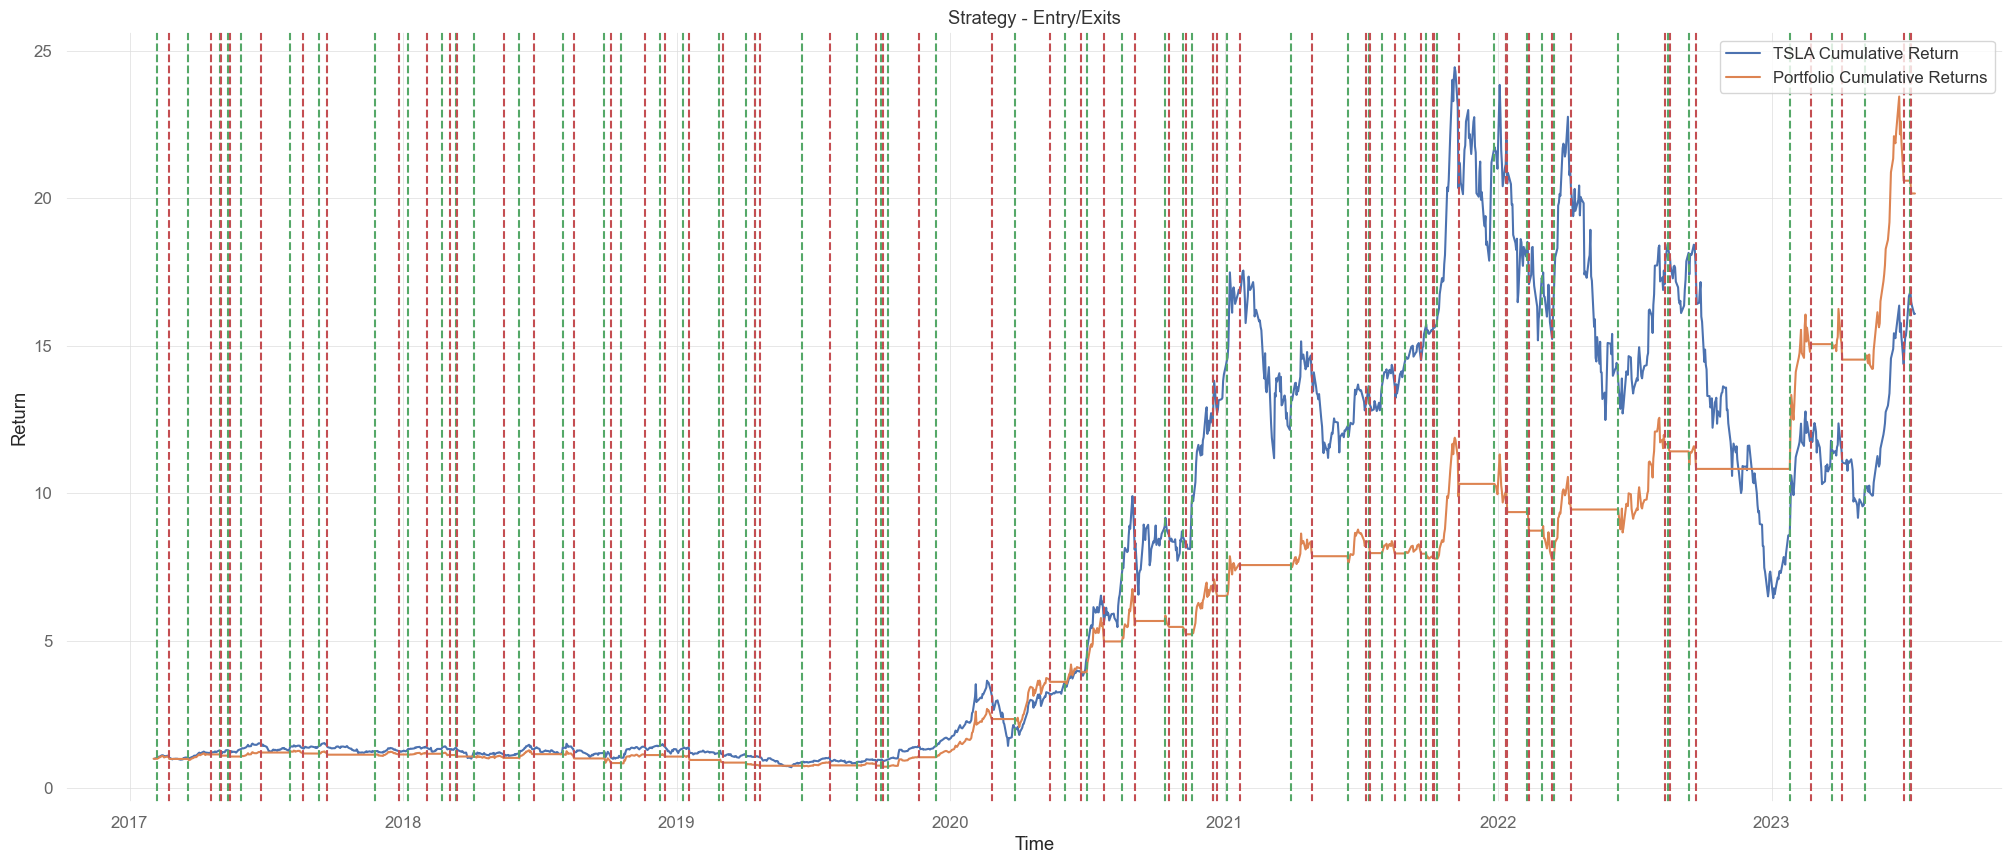

In [557]:
demo.plot_strategy()

In [558]:
# So Counter function Overrides list... which is used in the iterator and everywhere else... this will clear it from any values and resolve the 'list' error, run as needed
del list

NameError: name 'list' is not defined